In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy import optimize
from tqdm import tqdm

from interaction import potential
from counterterm import local_LO_counterterm
from constants import MU, BETA4
from utility import log_mesh

plt.style.use('science')
ratio = 4/3
h = 3

In [2]:
mm = np.loadtxt('spectra_Mott_Massey_hp.txt')
b2_mm = np.abs(mm)
gamma_mm = np.sqrt(2*MU*b2_mm)
r0_mm = -1/gamma_mm * np.log(1e-10)

In [24]:
DEFAULT_R_0 = 50
DEFAULT_ENDPTS = np.array([1e-3, 100])
INIT_CONDITIONS = np.array([0, 1])

# Solves the radial (u) Schrödinger equation and returns arrays of r and u.
def solve_se(v_r, energy, rmin=1e-9, rmax=50.0, numpts=10000):
    r_values = np.linspace(rmin, rmax, numpts)
    g = lambda u, r: np.array([u[1], (2 * MU) * (v_r(r) - energy) * u[0]])
    w = odeint(g, INIT_CONDITIONS, r_values, mxstep=20000)
    return (r_values, w[:, 0])


def wave_function(v_r, energy, r_endpts=DEFAULT_ENDPTS):
    sol = solve_ivp(
        lambda r, phi: np.array([phi[1], 2*MU*(v_r(r) - energy) * phi[0]], dtype=object),
        r_endpts, [r_endpts[0], 1], rtol=1e-8, atol=1e-12,
        dense_output=True
    )
    return sol.sol


def normalization_constant(v_r, energy, r_max=100, tol=1e-12):
    r, wr = log_mesh(0, r_max, 3000)
    u = wave_function(v_r, energy)(r)[0]
    iC2 = np.dot(wr, u**2)
    return 1/np.sqrt(iC2)


def normalized_wave_function(v_r, energy, r_max=100, tol=1e-12):
    r, wr = log_mesh(0, r_max, 3000)
    u = wave_function(v_r, energy)(r)[0]
    iC2 = np.dot(wr, u**2)
    return 1/np.sqrt(iC2) * u


def f(energy, interaction,  r_0=DEFAULT_R_0, r_endpts=DEFAULT_ENDPTS):
    sol = wave_function(interaction, energy, r_endpts=r_endpts)
    return sol(r_0)[0]


def D(energy, interaction, r_0, endpts=DEFAULT_ENDPTS):
    sol = wave_function(interaction, energy, r_endpts=[1e-3, 1.1*r_0])
    u, up = sol(r_0)
    gamma = np.sqrt(2*MU*-energy)
    return gamma*u + up


def bound_state(interaction, guess, r_0=DEFAULT_R_0, r_endpts=DEFAULT_ENDPTS):
    result = optimize.fsolve(lambda en: D(en, interaction, r_0, endpts=r_endpts), guess)
    return result[0]

In [25]:
NUM_STATES = 14

In [26]:
rgf_lo = np.loadtxt(f'rgflow_local_lo_a0_fix_hp_n_14_coord_ir_corrected.txt')
spectra_lo = np.loadtxt(f'spectra_local_lo_a0_fix_hp_n_{NUM_STATES}.txt')

In [27]:
old_rgf_lo = np.loadtxt('rgflow_local_lo_a0_fix_hp_n_14_coord.txt')

In [28]:
n = rgf_lo.shape[0]

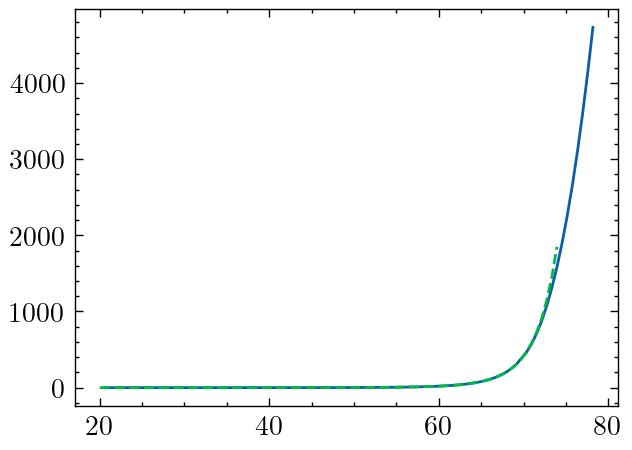

In [29]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot(BETA4/rgf_lo[:, 0], rgf_lo[:, 1])
ax.plot(BETA4/old_rgf_lo[:n, 0], old_rgf_lo[:n, 1], linestyle='--');

In [30]:
R_MESH = log_mesh(1e-3, 4, 4000)

class NLOResult:
    def __init__(self, R, c_0, spec_lo_momentum, r_mesh=R_MESH, **kwargs_bound_state):
        self.R = R
        self.c_0 = c_0
        self.spec_lo_mom = spec_lo_momentum.copy()
        self.k_lo_mom = np.sqrt(2*MU*-self.spec_lo_mom)
        r, wr = r_mesh
        
        self.potential = lambda r: potential(r, self.R) + self.c_0*local_LO_counterterm(r, self.R)
        self.spec_lo = np.array([
            bound_state(self.potential, en, r_0=r0) for (en, r0) in zip(self.spec_lo_mom, r0_mm)])
        self.b2_lo = np.abs(self.spec_lo)
            
        self.integrands = []
        self.matrix_elements = []

        for ((i, en), r0) in zip(enumerate(self.spec_lo), r0_mm):
            r, wr = log_mesh(0, r0, 4000)
            C = normalization_constant(self.potential, en, r_max=r0)
            u = C*wave_function(self.potential, en)(r)[0]
            integrand = local_LO_counterterm(r, R)*u**2
            self.integrands.append(integrand)
            self.matrix_elements.append(np.dot(wr, integrand))
        
        self.integrands = np.array(self.integrands)
        self.matrix_elements = np.array(self.matrix_elements)
        
        self.c_2 = 1/self.matrix_elements[-1] * (b2_mm[-1]/self.b2_lo[-1] - 1)
        self.b2_nlo = self.b2_lo * (1 + self.c_2*self.matrix_elements)

In [31]:
from scipy.interpolate import interp1d

In [32]:
def good_guess(cutoffs, spec_history, next_cutoff):
    interp_funcs = [interp1d(cutoffs, row, kind='cubic', fill_value='extrapolate') for row in spec_history.T]
    return np.array([f(next_cutoff) for f in interp_funcs])

In [42]:
results = []

for i in tqdm(range(rgf_lo.shape[0])):
    R, c0 = rgf_lo[i]
    
    if i < 6:
        spec_guess = spectra_lo[i, 1:]
    else:
        spec_history = np.array([results[j].spec_lo for j in range(i-5, i)])
        cutoffs = np.array([results[j].R for j in range(i-5, i)])
        spec_guess = good_guess(cutoffs, spec_history, R)
    
    results.append(NLOResult(*rgf_lo[i], spec_guess))    

 91%|██████████████████████████████████████▉    | 86/95 [13:37<02:40, 17.82s/it]/var/folders/_z/4zb077j96tz1_kb2vklbxydr0000gn/T/ipykernel_13157/4150212890.py:25: RuntimeWarning: overflow encountered in square
  iC2 = np.dot(wr, u**2)
/var/folders/_z/4zb077j96tz1_kb2vklbxydr0000gn/T/ipykernel_13157/971993178.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  self.c_2 = 1/self.matrix_elements[-1] * (b2_mm[-1]/self.b2_lo[-1] - 1)
/var/folders/_z/4zb077j96tz1_kb2vklbxydr0000gn/T/ipykernel_13157/971993178.py:31: RuntimeWarning: invalid value encountered in multiply
  self.b2_nlo = self.b2_lo * (1 + self.c_2*self.matrix_elements)
 99%|██████████████████████████████████████████▌| 94/95 [21:05<00:13, 13.47s/it]


KeyboardInterrupt: 

In [43]:
b2s_lo = np.array([res.b2_lo for  res in results])
b2s_nlo = np.array([res.b2_nlo for res in results])
Rs = np.array([res.R for res in results])

In [55]:
b2_mm = np.abs(np.loadtxt('spectrum_Mott_Massey_hp_coord.txt'))

In [56]:
n_results = len(results)

In [88]:
ii = np.where(BETA4/Rs < 68)[0]

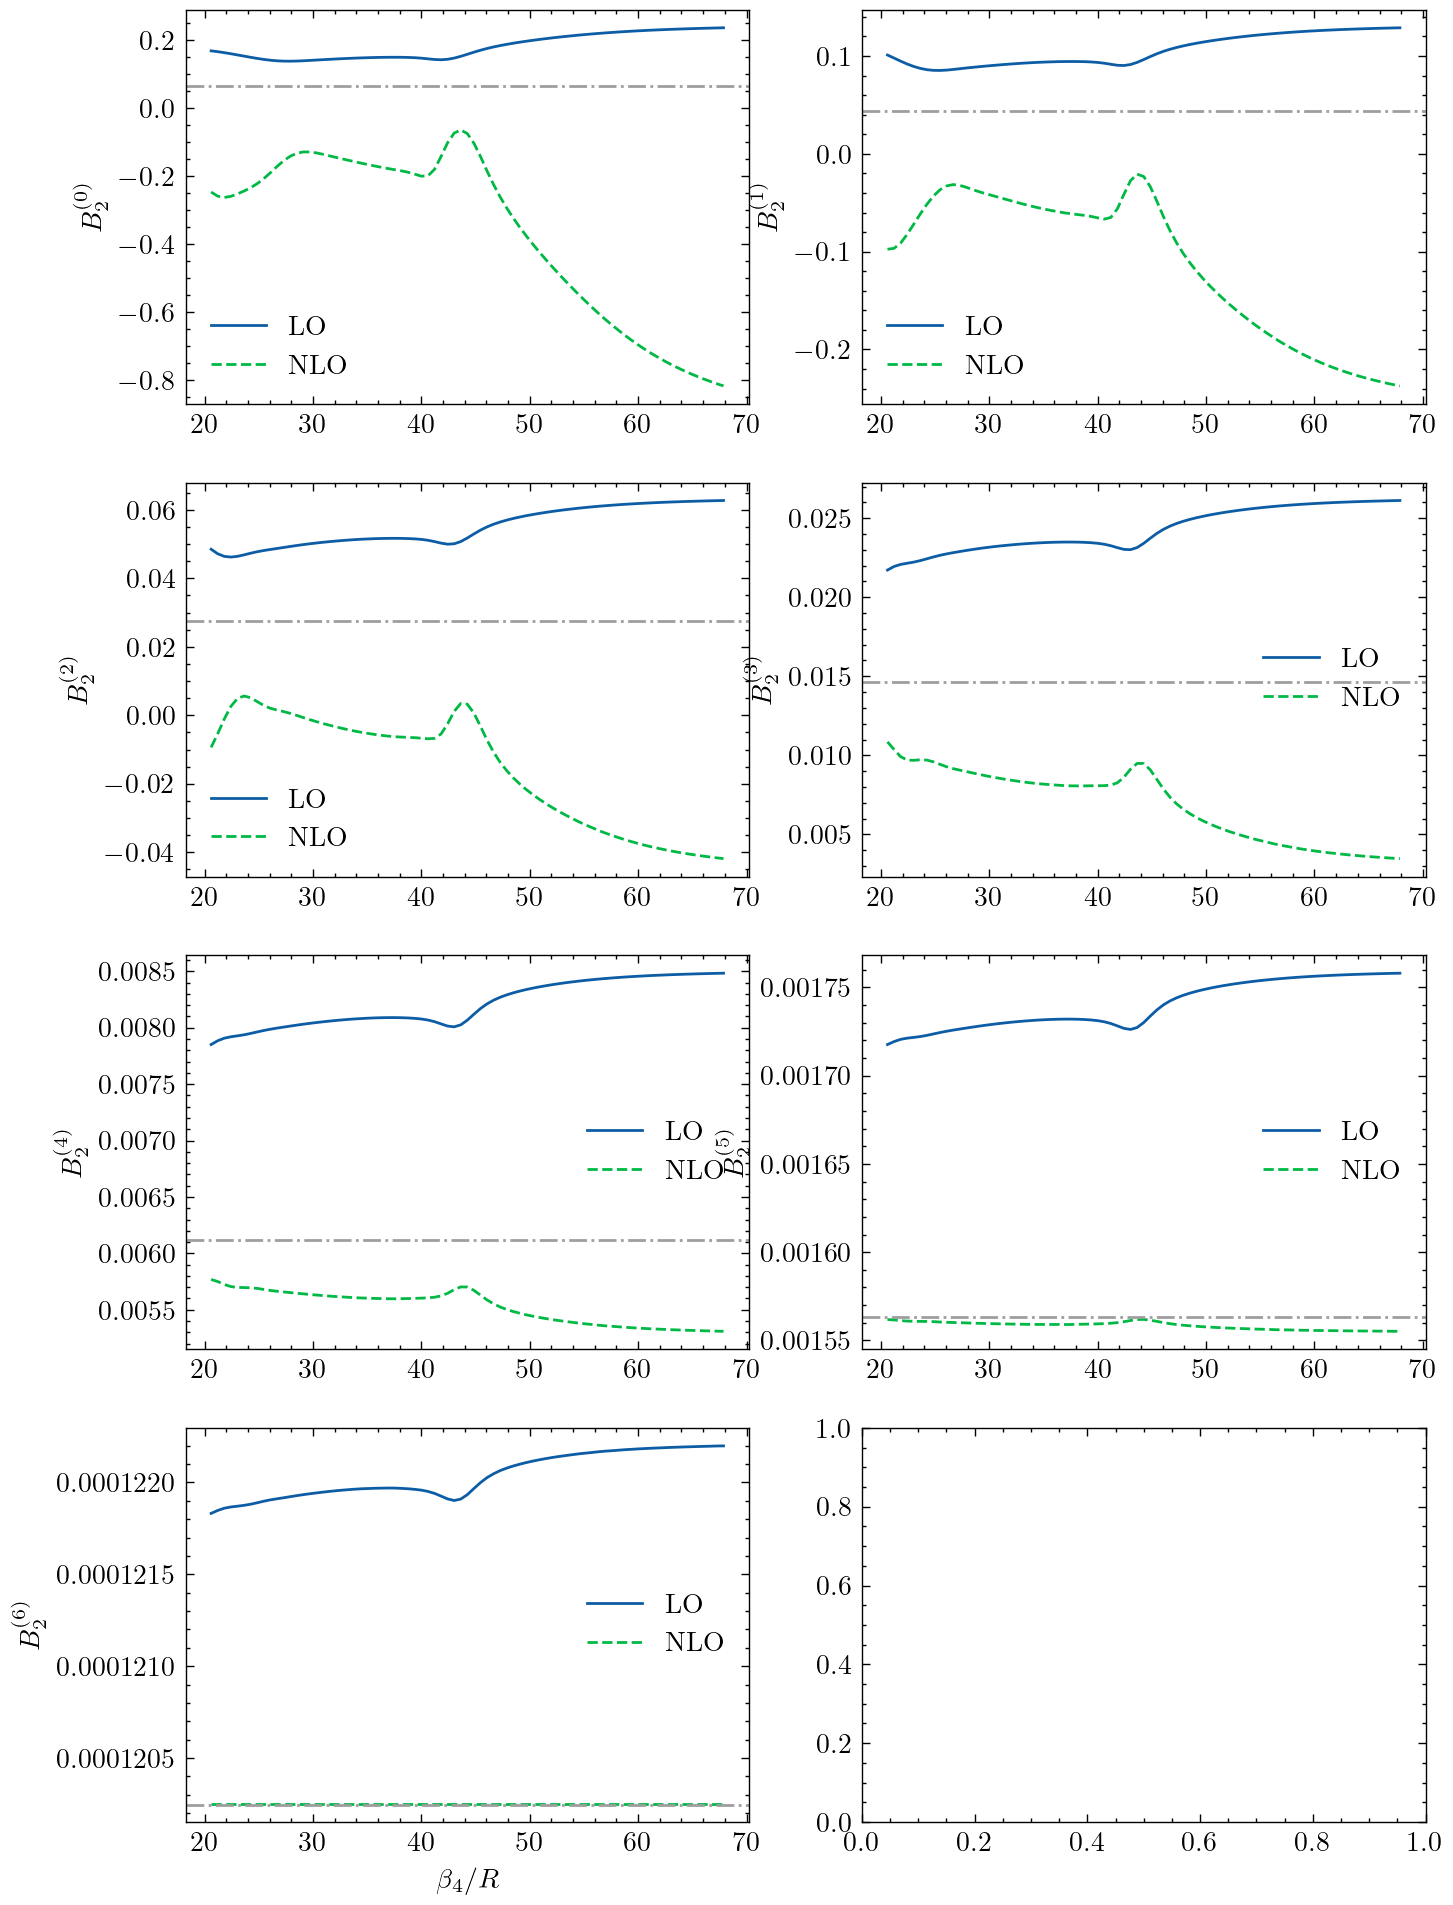

In [89]:
fig, ax = plt.subplots(4, 2, dpi=200, figsize=(2*ratio*h, 4*h))
fig.patch.set_facecolor('white')

for i in range(7):
    axij = ax[i//2, i%2]
    axij.plot(BETA4/Rs[ii], b2s_lo[ii, i], label='LO')
    axij.plot(BETA4/Rs[ii], b2s_nlo[ii, i], linestyle='--', label='NLO')
    axij.axhline(b2_mm[i], color='C6', linestyle='-.')
    axij.set_ylabel(r'$B_{2}^{(%d)}$' % (i))
    axij.legend()
#     axij.plot(BETA4/rgf_lo[:n_results, 0], np.abs(spectra_lo[:n_results, 1+i]))
    
    if i >= 6:
        ax[i//2, i%2].set_xlabel(r'$\beta_4/R$')


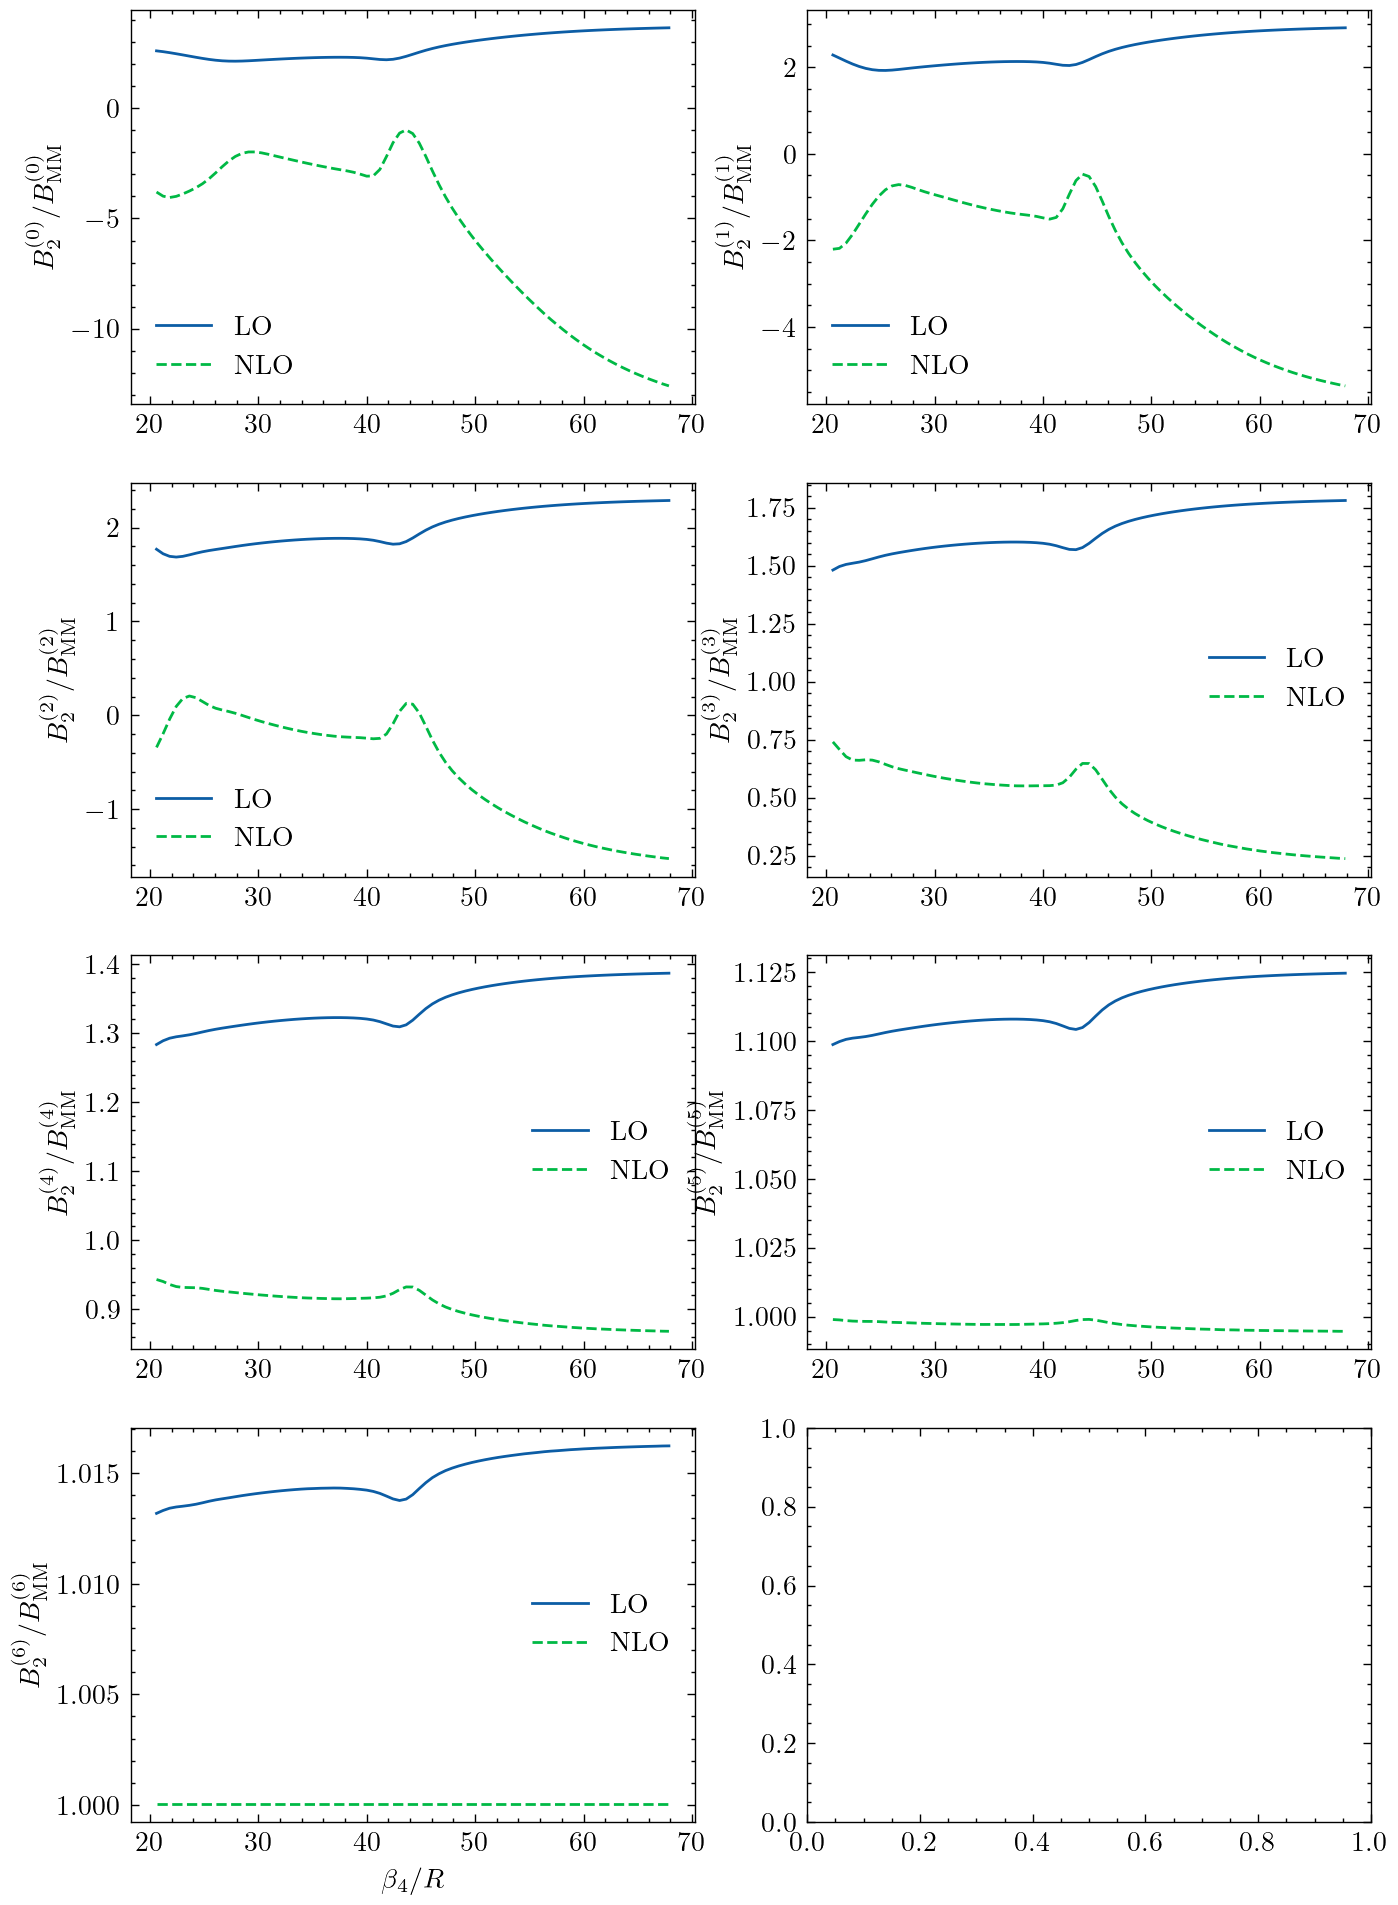

In [90]:
fig, ax = plt.subplots(4, 2, dpi=200, figsize=(2*ratio*h, 4*h))
fig.patch.set_facecolor('white')

for i in range(7):
    axij = ax[i//2, i%2]
    axij.plot(BETA4/Rs[ii], b2s_lo[ii, i] / b2_mm[i], label='LO')
    axij.plot(BETA4/Rs[ii], b2s_nlo[ii, i] / b2_mm[i], linestyle='--', label='NLO')
#     axij.axhline(b2_mm[i], color='C6', linestyle='-.')
    axij.set_ylabel(r'$B_{2}^{(%d)}/B_{\rm MM}^{(%d)}$' % (i, i))
    axij.legend()
    
    if i >= 6:
        ax[i//2, i%2].set_xlabel(r'$\beta_4/R$')


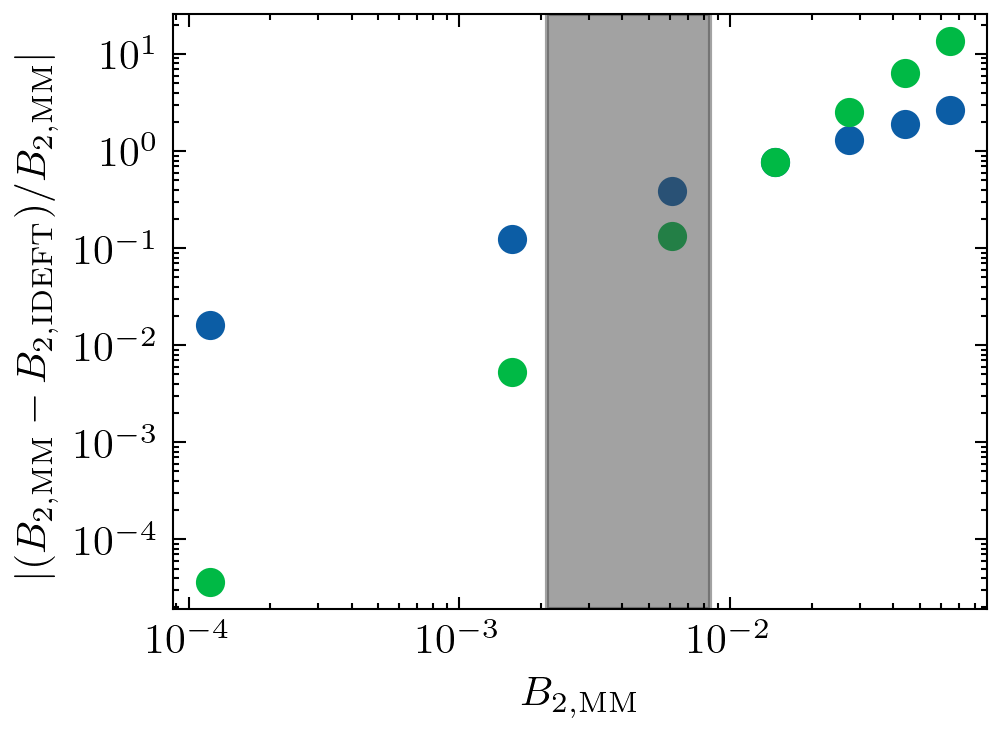

In [91]:
fig, ax = plt.subplots(dpi=300)
fig.patch.set_facecolor('white')

ax.scatter(b2_mm, np.abs((b2_mm - b2s_lo[ii[-1], :]) / b2_mm))
ax.scatter(b2_mm, np.abs((b2_mm - b2s_nlo[ii[-1], :]) / b2_mm))
ax.axvspan(1/(2*MU), 4/(2*MU), color='C5', alpha=0.5)

ax.set_xlabel(r'$B_{2,{\rm MM}}$')
ax.set_ylabel(r'$|(B_{2,{\rm MM}} - B_{2,{\rm IDEFT}})/B_{2,{\rm MM}}|$')

ax.set_yscale('log')
ax.set_xscale('log');

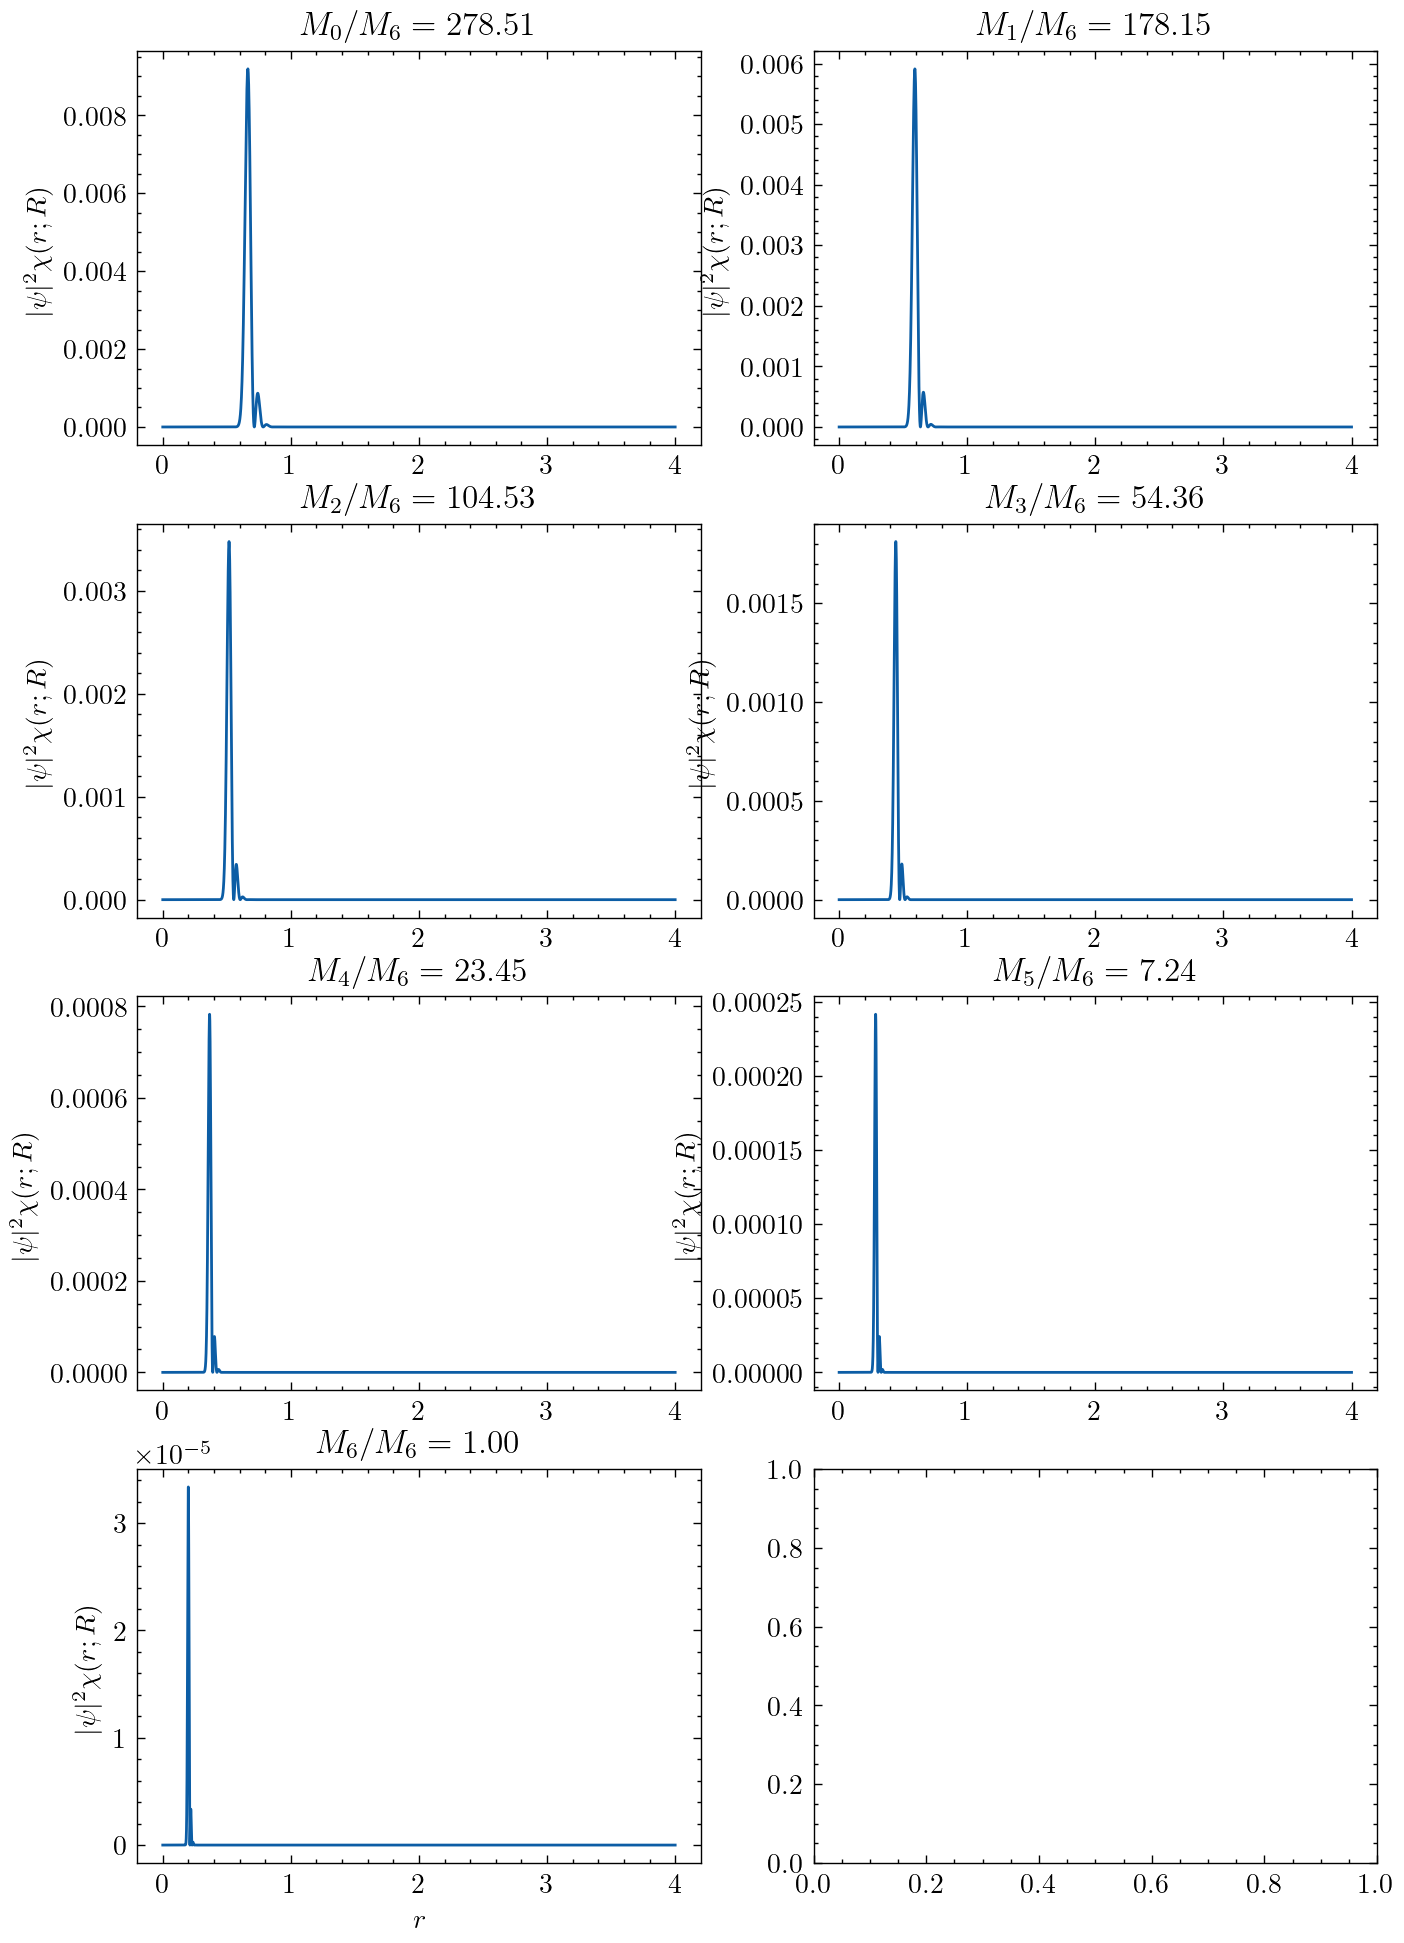

In [92]:
result = results[ii[-1]]

fig, ax = plt.subplots(4, 2, dpi=200, figsize=(2*ratio*h, 4*h))
fig.patch.set_facecolor('white')

for (i, en) in enumerate(result.spec_lo):
    integrand = result.integrands[i]
    Mi = result.matrix_elements[i]
    ax[i//2, i%2].plot(R_MESH[0], integrand)
    ax[i//2, i%2].set_title(f'$M_{i}/M_6 = {Mi/result.matrix_elements[6]:.2f}$')
    ax[i//2, i%2].set_ylabel(r'$|\psi|^2 \chi(r;R)$')
    if i >= 6:
        ax[i//2, i%2].set_xlabel(r'$r$')

In [93]:
ratios = []

for res in results:
    me = [res.matrix_elements[i] for i in range(7)]
    ratios.append([mi/me[-1] for mi in me])

/var/folders/_z/4zb077j96tz1_kb2vklbxydr0000gn/T/ipykernel_13157/4237779511.py:5: RuntimeWarning: invalid value encountered in double_scalars
  ratios.append([mi/me[-1] for mi in me])


In [94]:
ratios = np.array(ratios)

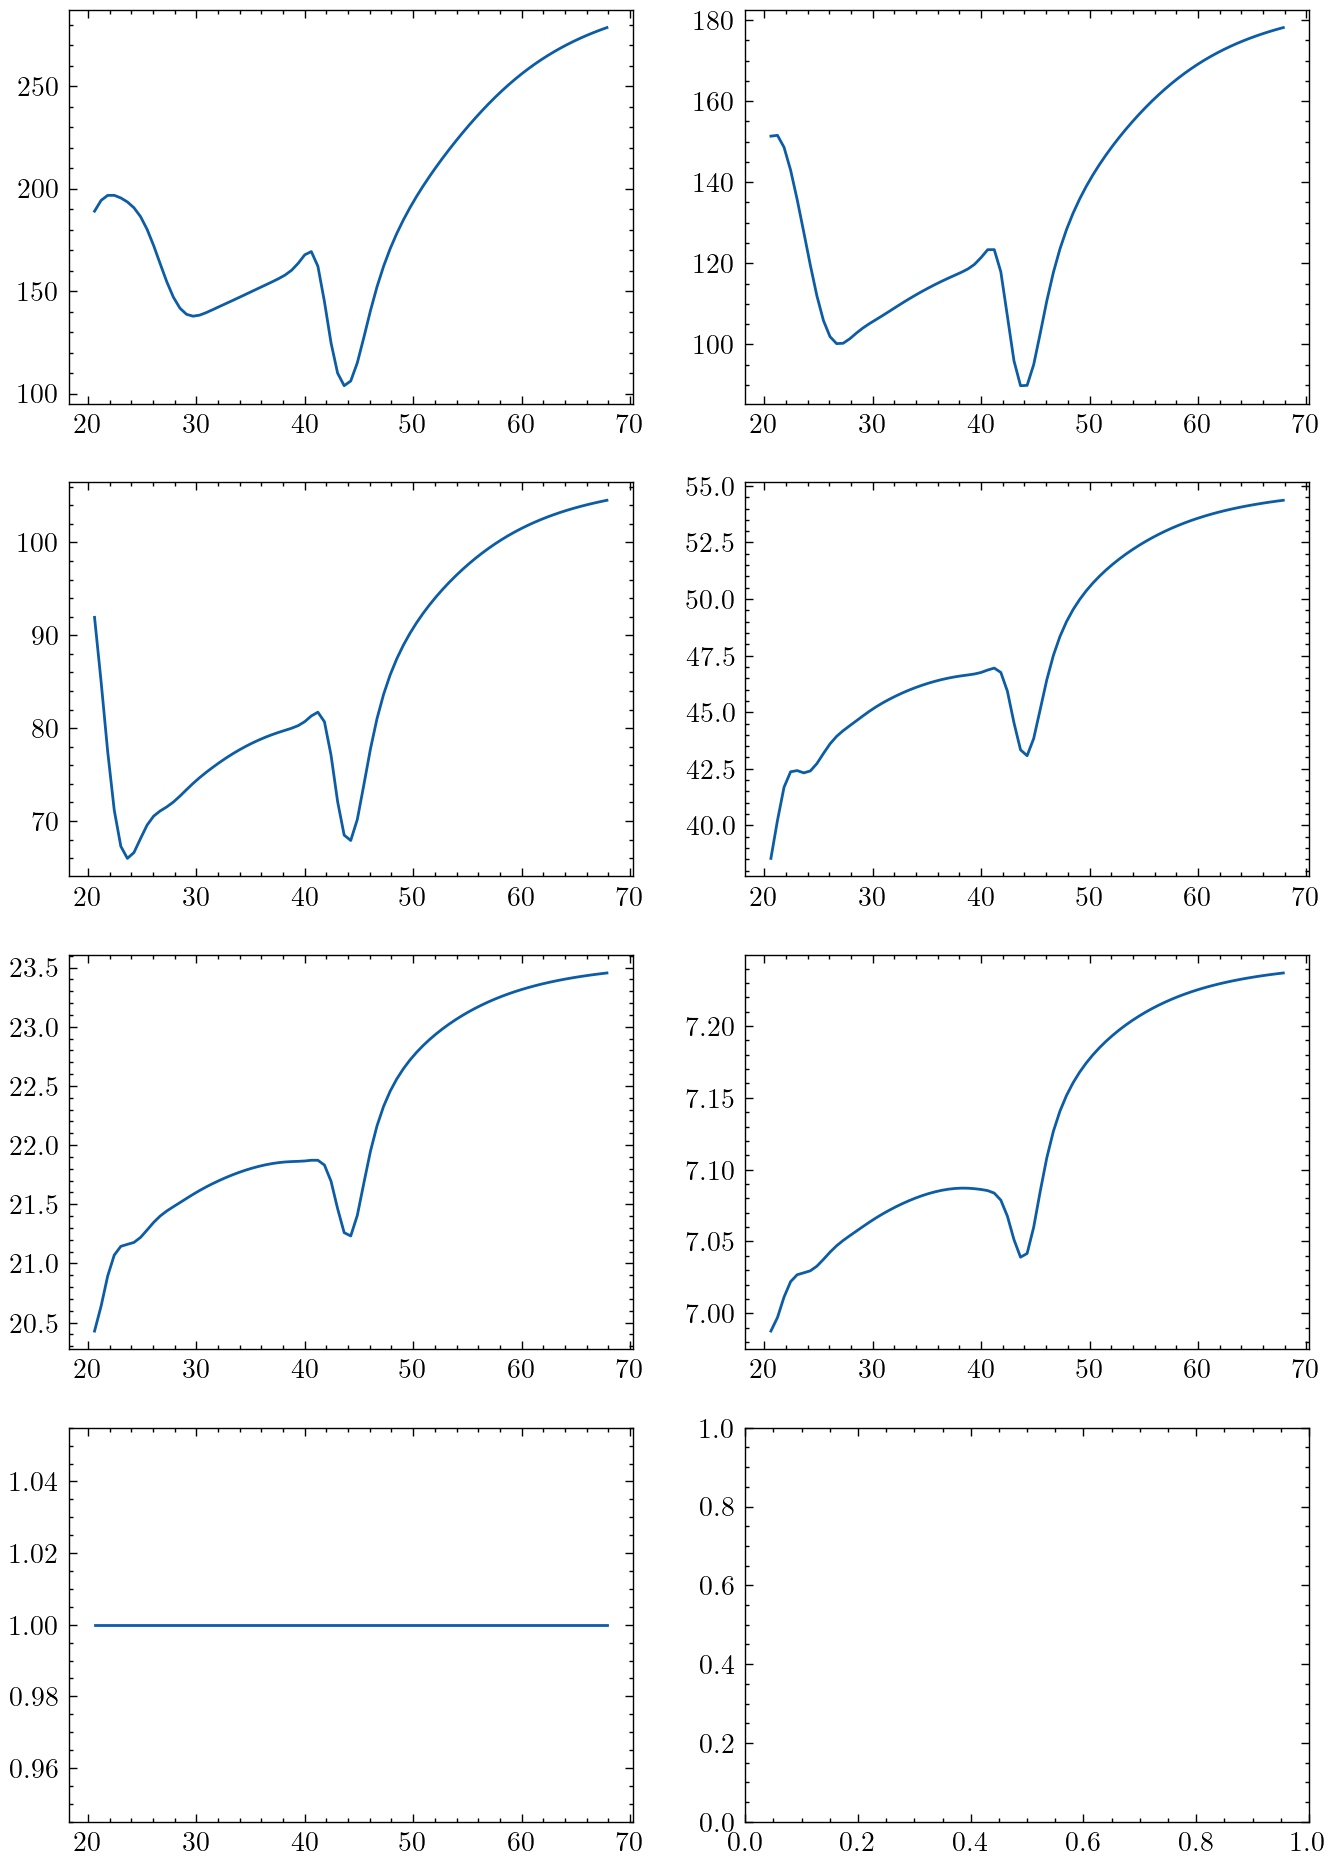

In [97]:
fig, ax = plt.subplots(4, 2, dpi=200, figsize=(2*ratio*h, 4*h))
fig.patch.set_facecolor('white')

for i in range(7):
    ax[i//2, i%2].plot(BETA4/Rs[ii], ratios[ii, i])


/var/folders/_z/4zb077j96tz1_kb2vklbxydr0000gn/T/ipykernel_13157/2597080214.py:10: RuntimeWarning: invalid value encountered in double_scalars
  ax[i//2, i%2].set_title(f'$M_{i}/M_6 = {Mi/result.matrix_elements[6]:.2f}$')
/var/folders/_z/4zb077j96tz1_kb2vklbxydr0000gn/T/ipykernel_13157/2597080214.py:10: RuntimeWarning: invalid value encountered in double_scalars
  ax[i//2, i%2].set_title(f'$M_{i}/M_6 = {Mi/result.matrix_elements[6]:.2f}$')
/var/folders/_z/4zb077j96tz1_kb2vklbxydr0000gn/T/ipykernel_13157/2597080214.py:10: RuntimeWarning: invalid value encountered in double_scalars
  ax[i//2, i%2].set_title(f'$M_{i}/M_6 = {Mi/result.matrix_elements[6]:.2f}$')
/var/folders/_z/4zb077j96tz1_kb2vklbxydr0000gn/T/ipykernel_13157/2597080214.py:10: RuntimeWarning: invalid value encountered in double_scalars
  ax[i//2, i%2].set_title(f'$M_{i}/M_6 = {Mi/result.matrix_elements[6]:.2f}$')
/var/folders/_z/4zb077j96tz1_kb2vklbxydr0000gn/T/ipykernel_13157/2597080214.py:10: RuntimeWarning: invalid value

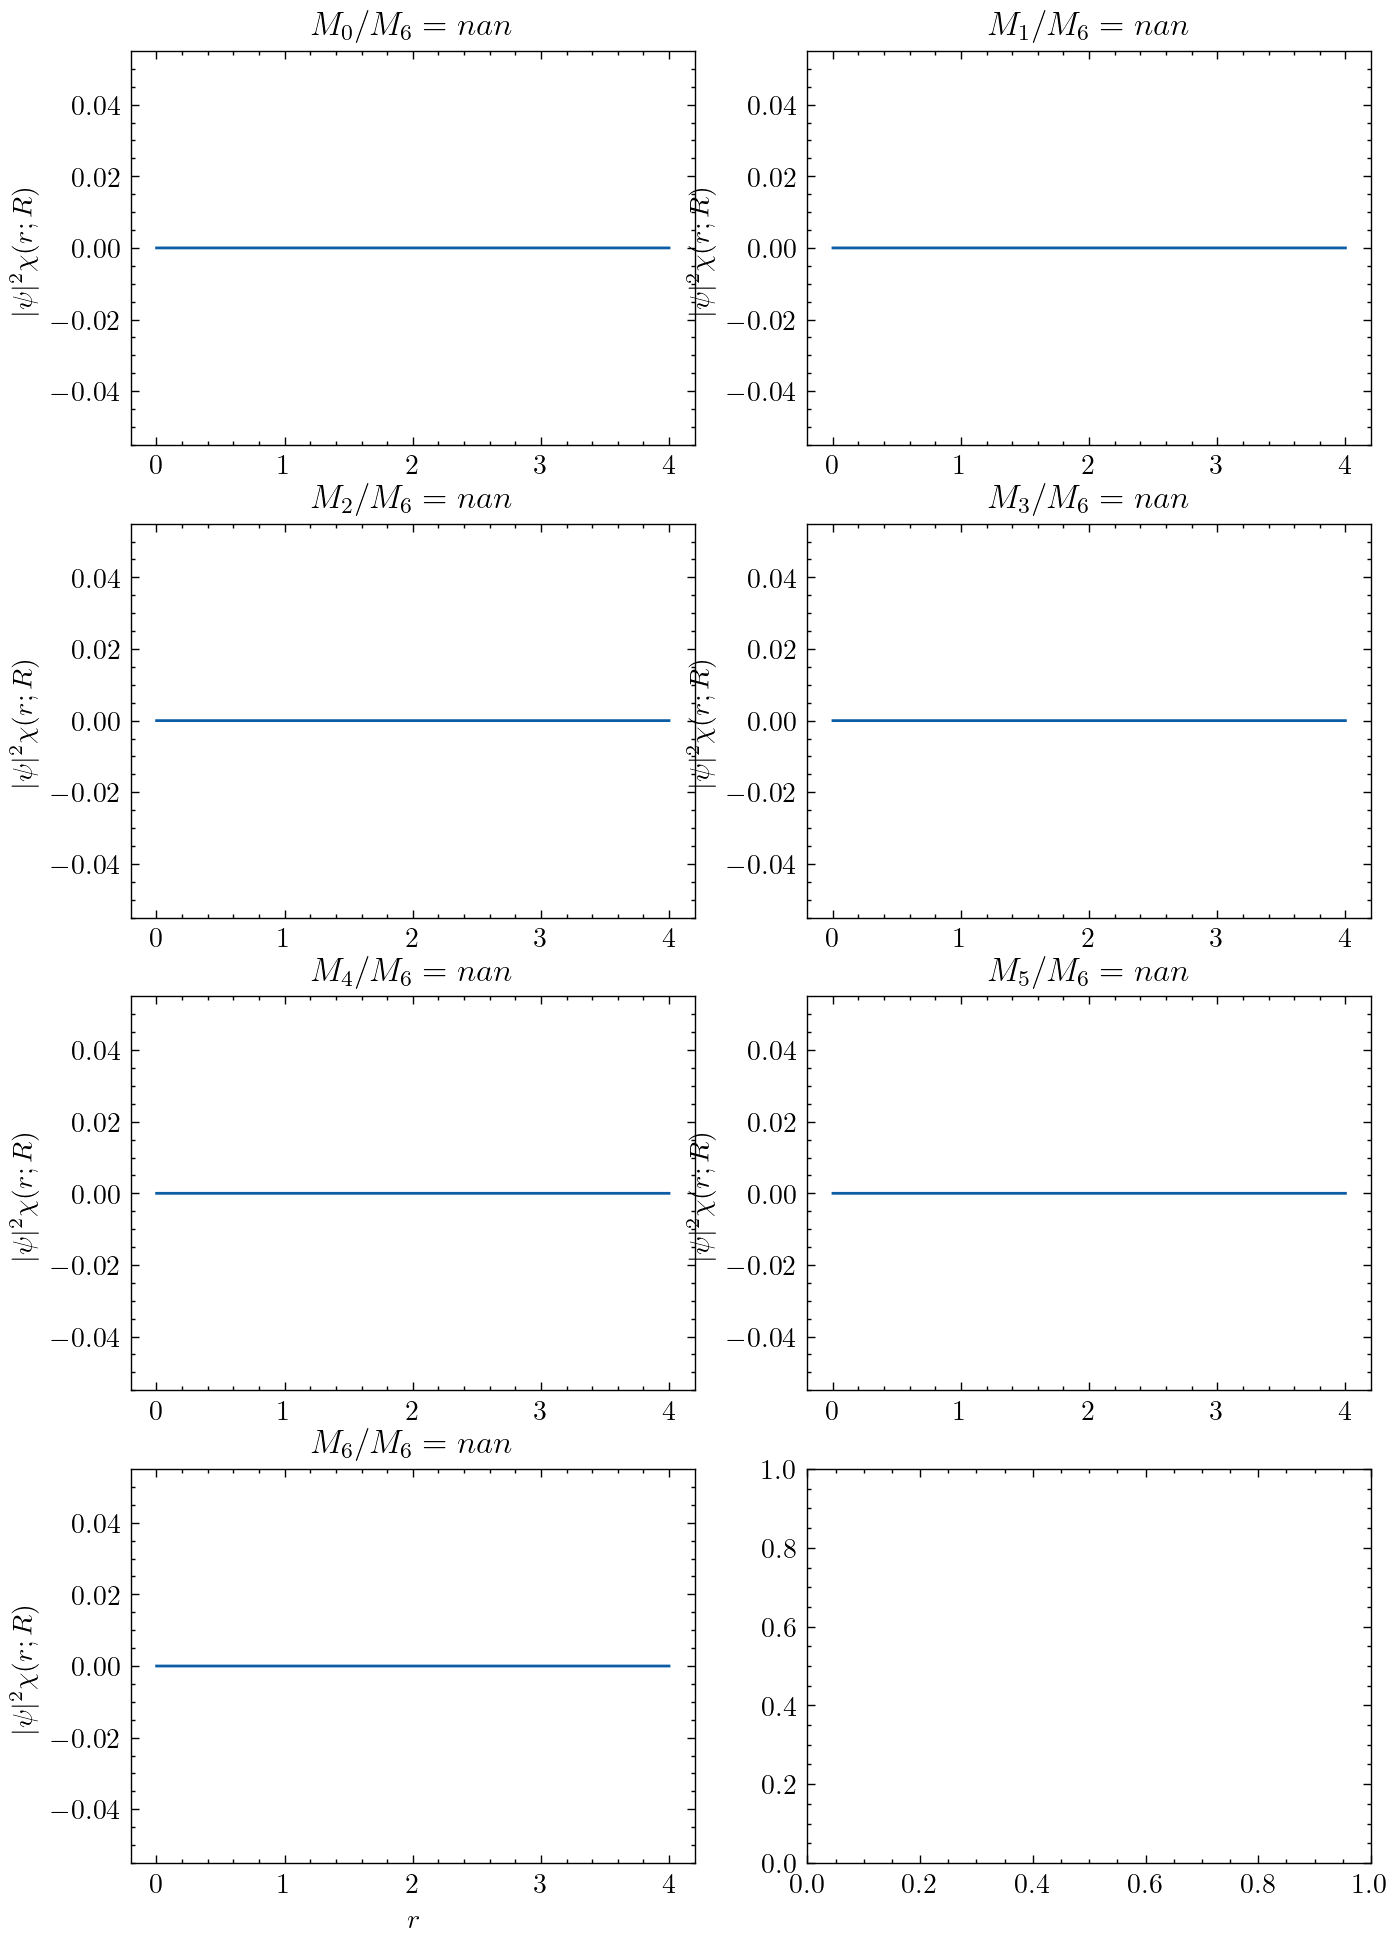

In [98]:
result = results[-1]

fig, ax = plt.subplots(4, 2, dpi=200, figsize=(2*ratio*h, 4*h))
fig.patch.set_facecolor('white')

for (i, en) in enumerate(result.spec_lo):
    integrand = result.integrands[i]
    Mi = result.matrix_elements[i]
    ax[i//2, i%2].plot(R_MESH[0], integrand)
    ax[i//2, i%2].set_title(f'$M_{i}/M_6 = {Mi/result.matrix_elements[6]:.2f}$')
    ax[i//2, i%2].set_ylabel(r'$|\psi|^2 \chi(r;R)$')
    if i >= 6:
        ax[i//2, i%2].set_xlabel(r'$r$')

In [103]:
rgf_nlo = np.array([[res.R, res.c_0, res.c_2] for res in results])

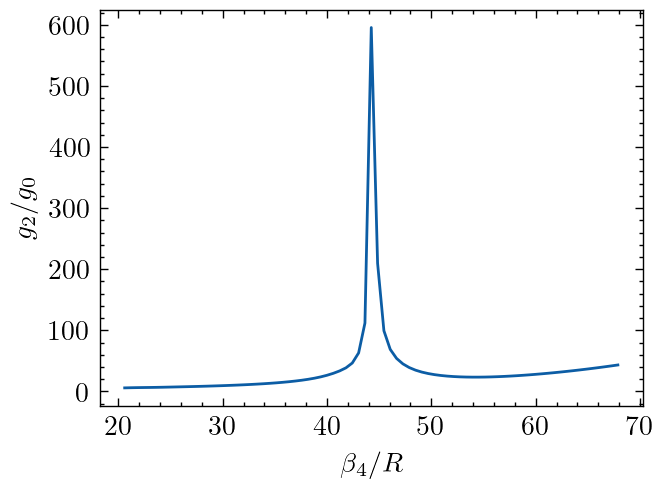

In [104]:
fig, ax = plt.subplots(dpi=200)
fig.patch.set_facecolor('white')

ax.plot(BETA4/rgf_nlo[ii, 0], np.abs(rgf_nlo[ii, 2] / rgf_nlo[ii, 1]))

ax.set_ylabel(r'$g_2/g_0$')
ax.set_xlabel(r'$\beta_4/R$');

In [105]:
np.savetxt(f'rgflow_local_nlo_a0_B6_fix_coord_hp_n_{NUM_STATES}_coord_ir_corrected.txt', rgf_nlo[ii])

np.savetxt(f'spectra_local_nlo_a0_B6_fix_coord_hp_n_{NUM_STATES}_coord_ir_corrected.txt', np.vstack((rgf_nlo[ii, 0], b2s_nlo[ii].T)).T)